In [1]:
import sys

sys.path.append("../")
sys.path.append("../../")

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
#sys.path.append('/home/exx/git/Tangram/')  # uncomment for local import
#import tangram2_coeff as tg
from scipy.io import mmread
#import utils
import scipy as sci
from scipy import sparse
import anndata
import json
import telegraph as tg
import tangram as tan

/gstore/home/huangh83/miniconda3/envs/tangram/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/gstore/home/huangh83/miniconda3/envs/tangram/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /gstore/home/huangh83/miniconda3/envs/tangram/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warn(f"Failed to load image Python extension: {e}")
/gstore/home/huangh83/miniconda3/envs/tangram/lib/python3.10/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/gstore/home/huangh83/miniconda3/envs/tangram/lib/python3

In [4]:
path = '/gstore/data/resbioai/tangram2_data/telegraph/res/ccc_data/original_dataset/'

In [5]:
ad_sc = sc.read_h5ad(path + 'bc.h5ad')
#ad_sc = ad_sc[ad_sc.obs['celltype_major'] != 'Normal Epithelial']

In [6]:
label_used = 'celltype_major'

In [7]:
ad_sp = sc.read_h5ad('/gstore/data/resbioai/tangram2_data/telegraph/res/deconvolution/ad_sp.h5ad')
ad_sc_paired = sc.read_h5ad('/gstore/data/resbioai/tangram2_data/telegraph/res/deconvolution/ad_sc_paired.h5ad')
ad_sc_paired_unperfect = sc.read_h5ad('/gstore/data/resbioai/tangram2_data/telegraph/res/deconvolution/ad_sc_paired_unperfect.h5ad')

In [8]:
ad_sc_unpaired = ad_sc[(ad_sc.obs['orig.ident'] != 'CID44971')* (ad_sc.obs['subtype'] == 'TNBC')]

In [9]:
ad_sc_group = [ad_sc_paired, ad_sc_paired_unperfect, ad_sc_unpaired]

In [30]:
ad_map_tg2_cell = []
ad_map_tg2_integrate = []
ad_map_tg1_cell = []
for i in range(len(ad_sc_group)):        
    ad_sc_mapping = ad_sc_group[i].copy()
    ad_sp_mapping = ad_sp.copy()
    
    label_col = 'celltype_major'
    input_dict_1 = tg.met.utils.adatas_to_input({'from':ad_sc_mapping, 'to':ad_sp_mapping}, # provide the data to be used
                                                    categorical_labels={'from':[label_col]}, # include cluster labels in the design matrix
                                                  )
    
    tg.met.pp.StandardTangramV2.run(input_dict_1)
    
    map_res_1 = tg.met.map_methods.TangramV2Map.run(input_dict_1,
                                                num_epochs = 1000,
                                                density_prior='uniform',
                                             )
    
    input_dict_1.update(map_res_1)
    tg.met.pp.StandardScanpy.run(input_dict_1,target_objs = ['X_from'])
    
    input_dict_1['w'].index = input_dict_1['w']['cell_type']
    
    mapping_df = input_dict_1['T'].copy()
    composition = pd.DataFrame(index = mapping_df.index)
    for i in input_dict_1['w'].index:
        mapping_df[input_dict_1['D_from'][input_dict_1['D_from'][i] == 1.0].index] *= (input_dict_1['w'].loc[i, 'coefficient']/ ad_sc_mapping.obs['celltype_major'].value_counts()[i] * ad_sc_mapping.shape[0])
          
                                                                                       
        composition[i] = mapping_df[input_dict_1['D_from'][input_dict_1['D_from'][i] == 1.0].index].sum(axis=1)
    
    
    ad_map_tg2_integrate.append(composition)
    
    label_col = 'celltype_major'
    input_dict_1 = tg.met.utils.adatas_to_input({'from':ad_sc_mapping, 'to':ad_sp_mapping}, # provide the data to be used
                                                    categorical_labels={'from':[label_col]}, # include cluster labels in the design matrix
                                                  )
    
    tg.met.pp.StandardTangramV2.run(input_dict_1)
    
    map_res_1 = tg.met.map_methods.TangramV2Map.run(input_dict_1,
                                                num_epochs = 1000,
                                                density_prior='uniform',
                                                mode = 'cells',
                                             )
    
    input_dict_1.update(map_res_1)
    tg.met.pp.StandardScanpy.run(input_dict_1,target_objs = ['X_from'])
        
    ad_map = sc.AnnData(
            X=input_dict_1['T'].T.values,
        )
    ad_map.obs.index=input_dict_1['T'].columns
    ad_map.var.index=input_dict_1['T'].index
    
    ad_map.obs[label_col] = ad_sc_mapping.obs[label_col]
    
    ad_map_tg2_cell.append(ad_map)
    
    tan.pp_adatas(ad_sc_mapping, ad_sp_mapping)

    ad_map = tan.map_cells_to_space(ad_sc_mapping, ad_sp_mapping,
        mode="cells",
        device='cuda:0',
        cluster_label = label_used,
        density_prior='uniform',
    )

    ad_map_tg1_cell.append(ad_map)


INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 22389 genes and uniform density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Set Solid Seed
Score: 0.856, KL reg: 2.277, Entropy reg: -7.465
Score: 0.953, KL reg: 2.197, Entropy reg: -6.491
Score: 0.954, KL reg: 2.197, Entropy reg: -6.352
Score: 0.955, KL reg: 2.197, Entropy reg: -6.317
Score: 0.955, KL reg: 2.197, Entropy reg: -6.293
Score: 0.955, KL reg: 2.197, Entropy reg: -6.281
Score: 0.955, KL reg: 2.197, Entropy reg: -6.274
Score: 0.955, KL reg: 2.197, Entropy reg: -6.269
Score: 0.955, KL reg: 2.197, Entropy reg: -6.265
Score: 0.955, KL reg: 2.197, Entropy reg: -6.261


INFO:root:Renormalizing Single cell data
INFO:root:Begin training with 22389 genes and uniform density_prior in cells mode after renormalization
INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Set Solid Seed
Score: 0.909, KL reg: 0.000, Entropy reg: -17780.064
Score: 0.996, KL reg: 0.000, Entropy reg: -2258.960
Score: 0.997, KL reg: 0.000, Entropy reg: -1404.950
Score: 0.998, KL reg: 0.000, Entropy reg: -1285.618
Score: 0.998, KL reg: 0.000, Entropy reg: -1235.052
Score: 0.998, KL reg: 0.000, Entropy reg: -1208.457
Score: 0.998, KL reg: 0.000, Entropy reg: -1195.067
Score: 0.998, KL reg: 0.000, Entropy reg: -1179.194
Score: 0.998, KL reg: 0.000, Entropy reg: -1171.641
Score: 0.998, KL reg: 0.000, Entropy reg: -1167.978


INFO:root:Saving results..
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 22389 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Set Solid Seed
Score: 0.898, KL reg: 0.000, Entropy reg: -17780.064
Score: 0.987, KL reg: 0.000, Entropy reg: -3249.115
Score: 0.988, KL reg: 0.000, Entropy reg: -2583.119
Score: 0.988, KL reg: 0.000, Entropy reg: -2456.284
Score: 0.988, KL reg: 0.000, Entropy reg: -2403.434
Score: 0.988, KL reg: 0.000, Entropy reg: -2369.312
Score: 0.988, KL reg: 0.000, Entropy reg: -2341.341
Score: 0.988, KL reg: 0.000, Entropy reg: -2329.785
Score: 0.988, KL reg: 0.000, Entropy reg: -2323.201
Score: 0.988, KL reg: 0.000, Entropy reg: -2318.434


INFO:root:Saving results..
INFO:root:22389 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:22389 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 22389 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.366, KL reg: 0.000
Score: 0.921, KL reg: 0.013
Score: 0.922, KL reg: 0.012
Score: 0.923, KL reg: 0.012
Score: 0.923, KL reg: 0.012
Score: 0.923, KL reg: 0.012
Score: 0.923, KL reg: 0.012
Score: 0.923, KL reg: 0.012
Score: 0.923, KL reg: 0.012
Score: 0.923, KL reg: 0.012


INFO:root:Saving results..
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 20930 genes and uniform density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Set Solid Seed
Score: 0.846, KL reg: 2.277, Entropy reg: -7.465
Score: 0.951, KL reg: 2.197, Entropy reg: -6.491
Score: 0.952, KL reg: 2.197, Entropy reg: -6.356
Score: 0.952, KL reg: 2.197, Entropy reg: -6.317
Score: 0.952, KL reg: 2.197, Entropy reg: -6.299
Score: 0.952, KL reg: 2.197, Entropy reg: -6.291
Score: 0.953, KL reg: 2.197, Entropy reg: -6.282
Score: 0.953, KL reg: 2.197, Entropy reg: -6.276
Score: 0.953, KL reg: 2.197, Entropy reg: -6.272
Score: 0.953, KL reg: 2.197, Entropy reg: -6.269


INFO:root:Renormalizing Single cell data
INFO:root:Begin training with 20930 genes and uniform density_prior in cells mode after renormalization
INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Set Solid Seed
Score: 0.910, KL reg: 0.000, Entropy reg: -21254.609
Score: 0.962, KL reg: 0.000, Entropy reg: -12568.783
Score: 0.963, KL reg: 0.000, Entropy reg: -11149.660
Score: 0.963, KL reg: 0.000, Entropy reg: -10718.053
Score: 0.963, KL reg: 0.000, Entropy reg: -10528.504
Score: 0.963, KL reg: 0.000, Entropy reg: -10420.024
Score: 0.963, KL reg: 0.000, Entropy reg: -10355.729
Score: 0.963, KL reg: 0.000, Entropy reg: -10316.215
Score: 0.963, KL reg: 0.000, Entropy reg: -10287.549
Score: 0.963, KL reg: 0.000, Entropy reg: -10268.789


INFO:root:Saving results..
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 20930 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Set Solid Seed
Score: 0.896, KL reg: 0.000, Entropy reg: -21254.609
Score: 0.957, KL reg: 0.000, Entropy reg: -12358.362
Score: 0.958, KL reg: 0.000, Entropy reg: -11475.918
Score: 0.958, KL reg: 0.000, Entropy reg: -11218.784
Score: 0.958, KL reg: 0.000, Entropy reg: -11100.980
Score: 0.958, KL reg: 0.000, Entropy reg: -11037.889
Score: 0.958, KL reg: 0.000, Entropy reg: -10998.613
Score: 0.958, KL reg: 0.000, Entropy reg: -10972.216
Score: 0.958, KL reg: 0.000, Entropy reg: -10953.164
Score: 0.958, KL reg: 0.000, Entropy reg: -10942.312


INFO:root:Saving results..
INFO:root:20930 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:20930 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 20930 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.389, KL reg: 0.000
Score: 0.669, KL reg: 0.016
Score: 0.670, KL reg: 0.016
Score: 0.670, KL reg: 0.016
Score: 0.670, KL reg: 0.016
Score: 0.670, KL reg: 0.016
Score: 0.671, KL reg: 0.016
Score: 0.671, KL reg: 0.016
Score: 0.671, KL reg: 0.016
Score: 0.671, KL reg: 0.016


INFO:root:Saving results..
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 22147 genes and uniform density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Set Solid Seed
Score: 0.833, KL reg: 2.277, Entropy reg: -7.465
Score: 0.914, KL reg: 2.197, Entropy reg: -6.558
Score: 0.915, KL reg: 2.197, Entropy reg: -6.450
Score: 0.915, KL reg: 2.197, Entropy reg: -6.412
Score: 0.915, KL reg: 2.197, Entropy reg: -6.395
Score: 0.915, KL reg: 2.197, Entropy reg: -6.386
Score: 0.915, KL reg: 2.197, Entropy reg: -6.380
Score: 0.915, KL reg: 2.197, Entropy reg: -6.378
Score: 0.916, KL reg: 2.197, Entropy reg: -6.376
Score: 0.916, KL reg: 2.197, Entropy reg: -6.374


INFO:root:Renormalizing Single cell data
INFO:root:Begin training with 22147 genes and uniform density_prior in cells mode after renormalization


Set Solid Seed


INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Score: 0.885, KL reg: 0.000, Entropy reg: -182618.578
Score: 0.934, KL reg: 0.000, Entropy reg: -57891.914
Score: 0.936, KL reg: 0.000, Entropy reg: -24371.320
Score: 0.937, KL reg: 0.000, Entropy reg: -19829.367
Score: 0.937, KL reg: 0.000, Entropy reg: -18480.027
Score: 0.937, KL reg: 0.000, Entropy reg: -17908.705
Score: 0.937, KL reg: 0.000, Entropy reg: -17561.395
Score: 0.937, KL reg: 0.000, Entropy reg: -17367.773
Score: 0.937, KL reg: 0.000, Entropy reg: -17324.180
Score: 0.938, KL reg: 0.000, Entropy reg: -17249.260


INFO:root:Saving results..
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 22147 genes and uniform density_prior in cells mode...


Set Solid Seed


INFO:root:Printing scores every 100 epochs.


Set Solid Seed
Score: 0.863, KL reg: 0.000, Entropy reg: -182618.578
Score: 0.924, KL reg: 0.000, Entropy reg: -54147.172
Score: 0.926, KL reg: 0.000, Entropy reg: -34935.914
Score: 0.926, KL reg: 0.000, Entropy reg: -31016.516
Score: 0.927, KL reg: 0.000, Entropy reg: -29444.559
Score: 0.927, KL reg: 0.000, Entropy reg: -28667.855
Score: 0.927, KL reg: 0.000, Entropy reg: -28180.557
Score: 0.927, KL reg: 0.000, Entropy reg: -27877.246
Score: 0.927, KL reg: 0.000, Entropy reg: -27689.922
Score: 0.927, KL reg: 0.000, Entropy reg: -27566.242


INFO:root:Saving results..
INFO:root:22147 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:22147 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 22147 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.378, KL reg: 0.000
Score: 0.747, KL reg: 0.016
Score: 0.752, KL reg: 0.015
Score: 0.753, KL reg: 0.015
Score: 0.753, KL reg: 0.015
Score: 0.754, KL reg: 0.015
Score: 0.754, KL reg: 0.015
Score: 0.754, KL reg: 0.015
Score: 0.754, KL reg: 0.015
Score: 0.754, KL reg: 0.015


INFO:root:Saving results..


In [31]:
order = ad_sp.obsm['ct_counts'].columns

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

<Figure size 640x480 with 0 Axes>

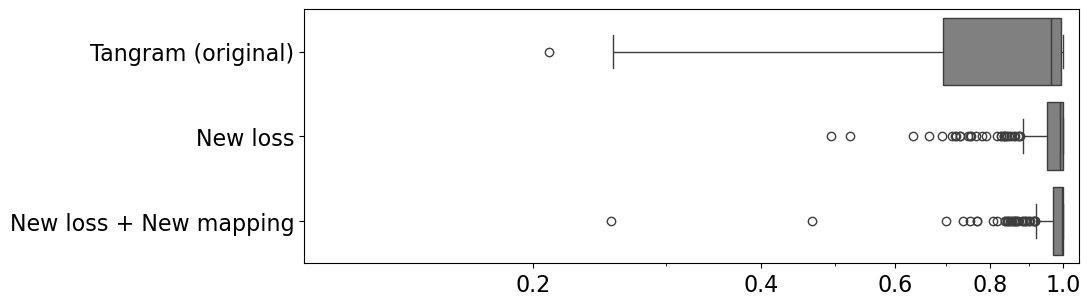

<Figure size 640x480 with 0 Axes>

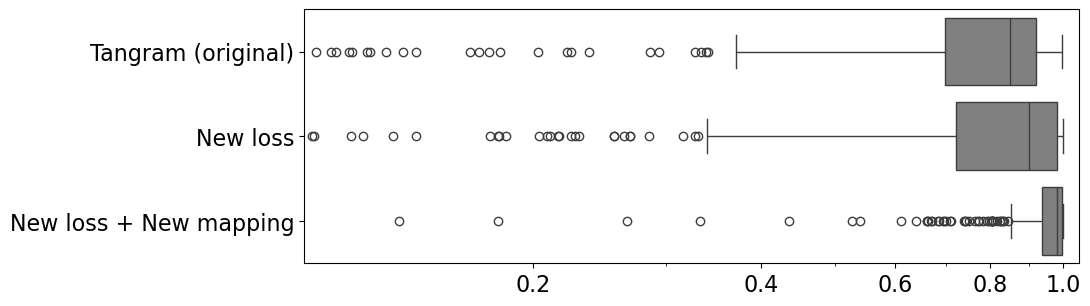

In [39]:
result_df = pd.DataFrame(index = ad_sp.obs.index)

# i = 0 perfectly paired
# i = 1 paired
# i = 2 unpaired
for i in range(1, 3): #(len(ad_map_tg2_cluster)):   
    ad_map = ad_map_tg1_cell[i]
    ad_map_subtype = sc.AnnData(
        X=np.zeros((len(order),ad_map.shape[1])),
    )
    ad_map_subtype.var.index = ad_map.var.index
    ad_map_subtype.obs.index = order

    for j in ad_map_subtype.obs.index:
        ad_map_subtype[ad_map_subtype.obs.index == j] = ad_map[ad_map.obs[label_used] == j].X.sum(axis = 0)

    ad_map_subtype.obs[label_used] = ad_map_subtype.obs.index
    cos = cosine_similarity(ad_map_subtype[order].X.T, ad_sp.obsm['ct_proportions'].values)
    result_df['Tangram (original)'] = cos.diagonal()
    
    ad_map = ad_map_tg2_cell[i]
    ad_map_subtype = sc.AnnData(
        X=np.zeros((len(order),ad_map.shape[1])),
    )
    ad_map_subtype.var.index = ad_map.var.index
    ad_map_subtype.obs.index = order

    for j in ad_map_subtype.obs.index:
        ad_map_subtype[ad_map_subtype.obs.index == j] = ad_map[ad_map.obs[label_used] == j].X.sum(axis = 0)

    ad_map_subtype.obs[label_used] = ad_map_subtype.obs.index
    cos = cosine_similarity(ad_map_subtype[order].X.T, ad_sp.obsm['ct_proportions'].values)
    result_df['New loss'] = cos.diagonal()
    
    composition = ad_map_tg2_integrate[i]
    cos = cosine_similarity(composition[order].values, ad_sp.obsm['ct_proportions'].values)
    
    result_df['New loss + New mapping'] = cos.diagonal()
    
    
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 3.3))
    sns.boxplot(result_df[['Tangram (original)', 'New loss', 'New loss + New mapping']], orient='h', color='grey', ax=ax)
    plt.xticks(fontsize=16) #rotation=45, 
    plt.yticks(fontsize=16)
    plt.xscale('log')
    ax.set_xlim([0.1, 1.05])  # Start from 0.2 since 0 cannot be represented on log scale
    desired_ticks = [0.2, 0.4, 0.6, 0.8, 1.0]
    ax.set_xticks(desired_ticks)
    ax.set_xticklabels(['0.2', '0.4',  '0.6', '0.8', '1.0'])
    
    plt.show()

<Figure size 640x480 with 0 Axes>

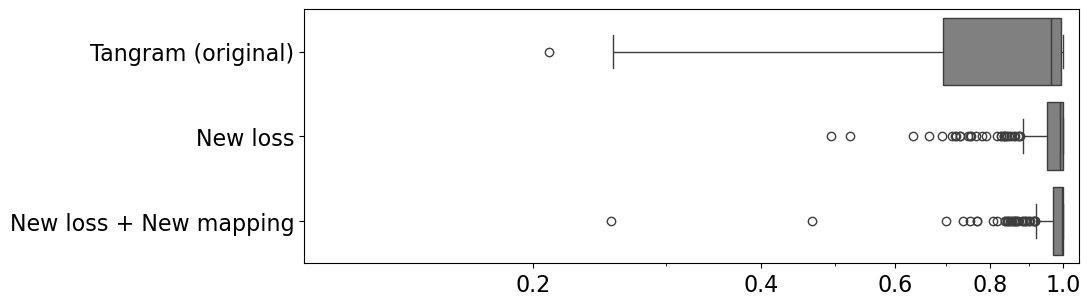

In [37]:
#sns.reset_defaults()
plt.clf()
fig, ax = plt.subplots(figsize=(10, 3.3))
sns.boxplot(result_df[['Tangram (original)', 'New loss', 'New loss + New mapping']], orient='h', color='grey', ax=ax)
plt.xticks(fontsize=16) #rotation=45, 
plt.yticks(fontsize=16)
plt.xscale('log')
ax.set_xlim([0.1, 1.05])  # Start from 0.2 since 0 cannot be represented on log scale
desired_ticks = [0.2, 0.4, 0.6, 0.8, 1.0]
ax.set_xticks(desired_ticks)
ax.set_xticklabels(['0.2', '0.4',  '0.6', '0.8', '1.0'])

#plt.savefig('paired_log.jpg', dpi=300, bbox_inches = 'tight')
#plt.title('Perfectly Paired datasets')